In [28]:
import os
import sys
import numpy as np
from typing import Optional, Union, List
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helper_functions import remove_unused_wires

In [29]:
from qiskit import pulse, transpile, schedule
from qiskit_dynamics.backend.dynamics_backend import _get_backend_channel_freqs, DynamicsBackend
from qiskit.circuit import QuantumCircuit, QuantumRegister, ParameterVector, Gate
from qiskit.circuit.library.standard_gates import ECRGate, SXGate
from qiskit.providers import Backend, BackendV1, BackendV2
from qiskit_experiments.calibration_management import Calibrations, FixedFrequencyTransmon, EchoedCrossResonance
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeValencia, FakeJakarta, FakeJakartaV2, FakeHanoi, FakeCairo, FakeCambridge
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, gate_map, plot_gate_map
from qiskit.visualization.pulse_v2 import IQXStandard

Backend basis gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']


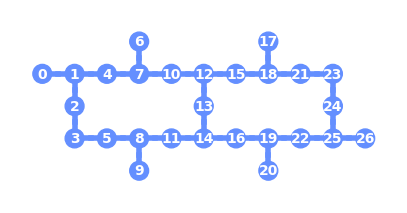

In [30]:
fake_backend = FakeHanoi() # mimics the bahaviour of a 27-qubits hardware
fake_backend_v2 = FakeJakartaV2
print('Backend basis gates:', fake_backend.configuration().basis_gates)
plot_gate_map(fake_backend)

In [31]:
def get_sx_params(backend, physical_qubits):
    """
    Retrieve parameters for an SX gate from a quantum backend.

    This function retrieves the default parameters for an SX gate, including amplitude, beta, sigma, and duration,
    from a given quantum backend.

    Parameters:
    - backend (Backend): The quantum backend from which to retrieve the parameters.
    - physical_qubits (Union[int, tuple, list]): The physical qubits on which the SX gate is applied.
    
    Returns:
    - default_params (dict): A dictionary containing default parameters for the SX gate.
    - basis_gate_instructions (InstructionSchedule): The instruction schedule for the SX gate.
    - instructions_array (numpy.ndarray): An array of instructions for the SX gate.
    """


    if isinstance(backend, BackendV1):
        instruction_schedule_map = backend.defaults().instruction_schedule_map
    else:
        instruction_schedule_map = backend.target.instruction_schedule_map()

    basis_gate_instructions = instruction_schedule_map.get('sx', qubits=physical_qubits)
    instructions_array = np.array(basis_gate_instructions.instructions)[:,1]

    sx_pulse = basis_gate_instructions.instructions[0][1].pulse 

    default_params = {
        ("amp", physical_qubits, "sx"): sx_pulse.amp,
        # ("angle", physical_qubits, "sx"): sx_pulse.angle,
        ("β", physical_qubits, 'sx'): sx_pulse.beta,
        ("σ", physical_qubits, "sx"): sx_pulse.sigma,
        ("duration", physical_qubits, "sx"): sx_pulse.duration
    }

    return default_params, basis_gate_instructions, instructions_array

In [32]:
def custom_sx_schedule(backend: Backend, physical_qubits=Union[int, tuple, list], params: ParameterVector=None):
    """
    Generate a custom parameterized schedule for an SX gate.

    This function generates a custom parameterized schedule for an SX gate on specified physical qubits
    with the given parameters.

    Parameters:
    - backend (Backend): The quantum backend used to obtain default SX gate parameters.
    - physical_qubits (Union[int, tuple, list]): The physical qubits on which the SX gate is applied.
    - params (ParameterVector, optional): The parameter vector specifying the custom parameters for the SX gate.

    Returns:
    - parametrized_schedule (Schedule): A parameterized schedule for the SX gate with custom parameters.
    """
    
    # pulse_features = ["amp", "angle", "β", "σ"]
    pulse_features = ["amp", "β", "σ"]
 
    global n_actions
    assert n_actions == len(params), f"Number of actions ({n_actions}) does not match length of ParameterVector {params.name} ({len(params)})" 

    if isinstance(physical_qubits, int):
        physical_qubits = tuple(physical_qubits)

    new_params, _, _ = get_sx_params(backend=fake_backend, physical_qubits=physical_qubits)

    for i, feature in enumerate(pulse_features):
        new_params[(feature, physical_qubits, "sx")] += params[i]

    cals = Calibrations.from_backend(backend, [FixedFrequencyTransmon(["x", "sx"])],
                                        add_parameter_defaults=True)

    parametrized_schedule = cals.get_schedule("sx", physical_qubits, assign_params=new_params)

    return parametrized_schedule

# Example of a target gate: RX($\pi/2$) = $\sqrt{X}$

In [33]:
# SX gate as the target gat
sx_gate = {"gate": SXGate(), "register": [1]}
target = sx_gate
print(target)

{'gate': Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), 'register': [1]}


##### Quantum Circuit context

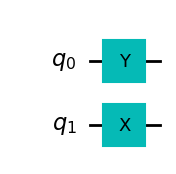

In [34]:
target_circuit = QuantumCircuit(2)
target_circuit.y(0)
# target_circuit.cx(0,1)
target_circuit.x([1])
target_circuit.draw("mpl")

Transpile the (context) quantum circuit to the provided (Fake-) Backend

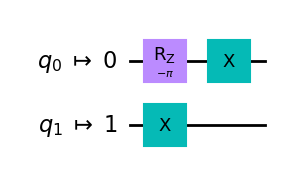

In [35]:
transpiled_circ = transpile(target_circuit, fake_backend, 
                              initial_layout=[0, 1],
                              basis_gates=fake_backend.configuration().basis_gates, 
                              optimization_level=1)

remove_unused_wires(transpiled_circ).draw("mpl")

Visualization of the "context" quantum circuit as a pulse sequence that the parametrized SX gate will then be added to

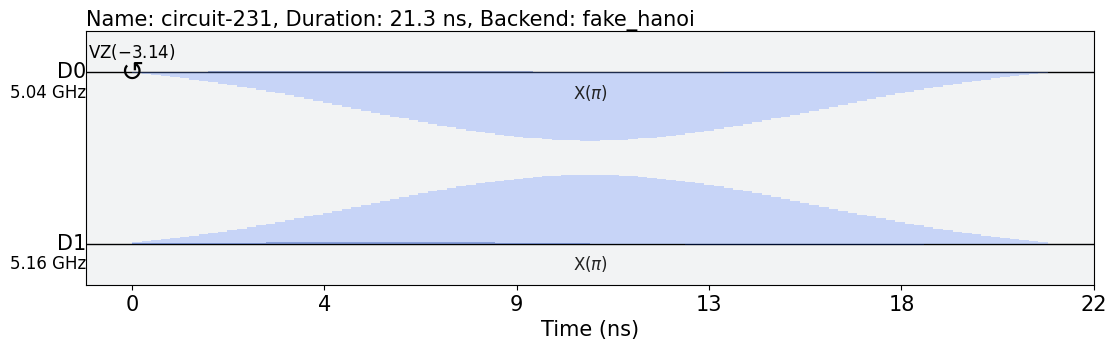

In [36]:
# schedule = build_schedule(transpiled_circ, fake_backend)
sched01 = schedule(transpiled_circ, fake_backend)
sched01.draw(backend=fake_backend, style=IQXStandard())

In [37]:
n_actions = 3 # number of parameters for the SX gate : amplitude and angle
print('Target gate:', target)

params = ParameterVector('theta', n_actions)

qubit = target["register"]
physical_qubits = tuple(qubit)

Target gate: {'gate': Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), 'register': [1]}


Add the parameterized SX gate to the quantum circuit, so that it exists in the context (=presence) of prior gates

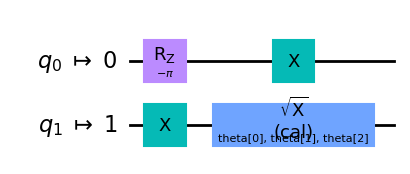

In [38]:
add_parametrized_circuit(qc=transpiled_circ, tgt_register=target['register'])
transpiled_circ.draw('mpl')

In [39]:
default_params, instructions, pulses  = get_sx_params(backend=fake_backend, physical_qubits=physical_qubits)

Visualization of the SX Pulse (it's a Derivative Removal by Adiabatic Gate (DRAG) pulse)

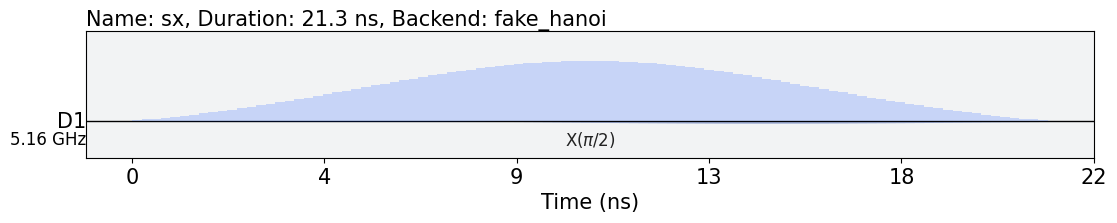

In [40]:
instructions.draw(backend=fake_backend, style=IQXStandard())

Visualization of the pulse sequence for the parameterized gate within the full circuit context

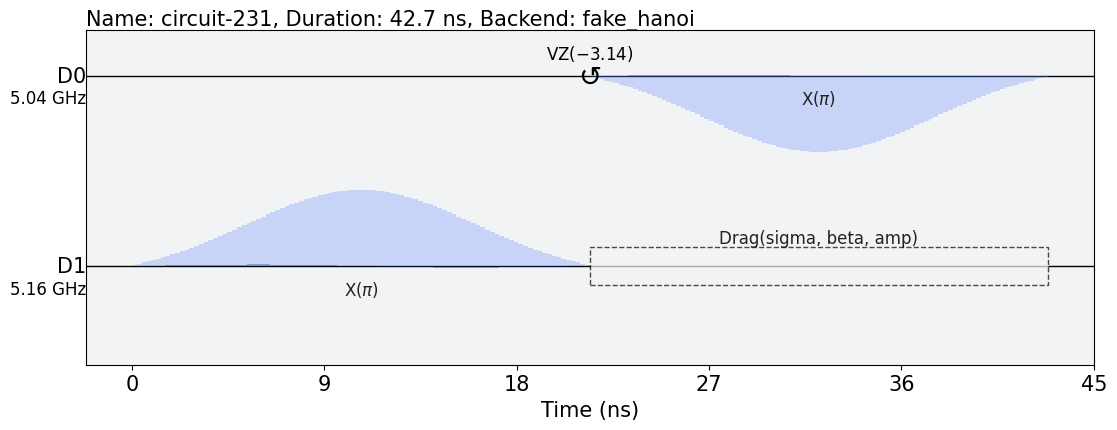

In [41]:
sched02 = schedule(transpiled_circ, fake_backend)
sched02.draw(backend=fake_backend, style=IQXStandard())